# Modelo híbrido CNN-LSTM para Predição de Rótulos de Compra e Venda de Ações da Vale S.A. em Série Temporal

Os rótulos de compra e venda de ações para a companhia Vale S.A. serão obtidos por uma rede neural que combina convolução e LSTM. Nesse problema o comportamento dos dados a curto prazo tem uma grande relevância, já que o comportamento dos dados muda drasticamente nos últimos anos, por isso vamos incluir uma camada convolucional 1D que irá extrair features locais, extraindo padrões de curto prazo.

Obeidat e Alqudah, 2021 Utilizaram um modelo híbrido 1D CNN-LSTM leve para classificação batimento por batimento em ECG, que teve uma acurácia superior a quando os modelos foram usados de forma isolada.

Alsumaidaee et al. (2023), avaliaram três modelos (1D-CNN, LSTM, híbrido 1D-CNN-LSTM) para detecção de falhas coroa em switchgear via sinais sonoros. O modelo híbrido alcançou precisão excepcional (99% no modo tempo e frequência), superando CNN e LSTM isoladamente.

Camadas convolucionais são sensíveis a diferenças de escalas, já que detectam padrões locais, o que pode fazer com que features com valores altos dominem as ativações. Deste modo normalização dos dados é recomendada. Jalali et al. (2025) usaram uma normalização robusta para tratar de um problema de predição e classificação de qualidade do ar. Normalização do tipo Min-Max foi usada por Thongjamroon et al. (2025) para predição de valores de petróleo.

# Obtenção dos dados de valores de ação e rótulos da companhia Vale S.A.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
TRAIN_ID = "10_LusVq47U1u-SF2FqgzgxEXqKrusMce"
TEST_ID  = "10_-7G-f4tO2PW8rE9ElN1tncE5Bt5Bk9"



URL_TRAIN = f"https://drive.google.com/uc?export=download&id={TRAIN_ID}"
URL_TEST  = f"https://drive.google.com/uc?export=download&id={TEST_ID}"

df_train = pd.read_csv(URL_TRAIN)
df_test  = pd.read_csv(URL_TEST)

print("Treino:", df_train.shape, "Teste:", df_test.shape)

Treino: (4808, 20) Teste: (1203, 20)


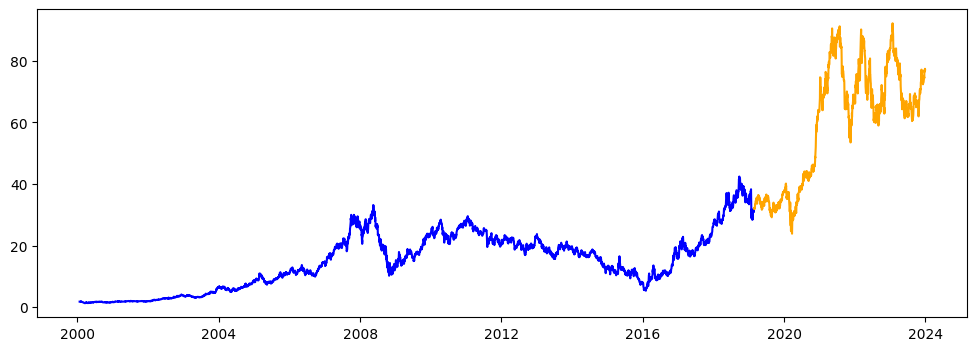

In [ ]:
plt.figure(figsize=(12,4))

df_train["Date"] = pd.to_datetime(df_train["Date"], errors="coerce")
df_test["Date"]  = pd.to_datetime(df_test["Date"], errors="coerce")

plt.plot(df_train["Date"], df_train["Close"], color="blue", label="Treino")
plt.plot(df_test["Date"], df_test["Close"], color="orange", label="Teste")

Uma particularidade desse dataset é que os conjunto de treino (representado em azul) e o conjunto de teste (em laranja) apresentam comportamentos bastante distintos. Depois de 2020 houve um aumento brusco no preço das ações dessa companhia, que foi seguido por oscilações de maior tamanho. Isso mais desafios na hora de obter bons resultados no ajuste de um modelo, especialmente no que diz respeito a obter uma boa acurácia de validação.

In [ ]:
df_train_drop = df_train.drop(columns=['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close'])
df_test_drop = df_test.drop(columns=['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close'])

In [ ]:
print(df_train['Label'].unique())
print(df_test['Label'].unique())

[ 1 -1]
[ 1 -1]


Vamos transformar os rótulo de -1 para 0, a fim de trabalhar com uma função de ativação do tipo sigmóide na camada de saída.

In [ ]:
df_train_drop["Label"] = df_train_drop["Label"].replace(-1, 0)
print(df_train_drop['Label'].unique())
df_test_drop["Label"] = df_test_drop["Label"].replace(-1, 0)
print(df_test_drop['Label'].unique())

[1 0]
[1 0]


In [ ]:
y_train = df_train_drop['Label']
X_train = df_train_drop.drop(columns=['Label'])
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)


y_test = df_test_drop['Label']
X_test = df_test_drop.drop(columns=['Label'])
X_teste_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
timesteps = 15 #janela de tempo
features = 1 #estamos trabalhando apenas com o valor de fechamento atenuado
num_classes = 1 #se compra ou não

### Testes com diferentes tipos de normalização

Como não foi encontrada uma unanimidade na literatura em relação a qual a melhor forma de normalizar os teste, foram feitos testes com vários tipos de scalers.

In [ ]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

X = pd.concat([X_train, X_test])

scaler_robust = RobustScaler()
scaler_robust.fit(X)
X_train_robust_scaled  = scaler_robust.transform(X_train)
X_test_robust_scaled = scaler_robust.transform(X_test)
X_treino_robust = X_train_robust_scaled.reshape(X_train_robust_scaled.shape[0], timesteps, 1)
X_teste_robust  = X_test_robust_scaled.reshape(X_test_robust_scaled.shape[0], timesteps, 1)


scaler_minmax = MinMaxScaler()
scaler_minmax.fit(X)
X_train_minmax_scaled = scaler_minmax.transform(X_train)
X_test_minmax_scaled  = scaler_minmax.transform(X_test)
X_treino_minmax = X_train_minmax_scaled.reshape(X_train_minmax_scaled.shape[0], timesteps, 1)
X_teste_minmax  = X_test_minmax_scaled.reshape(X_test_minmax_scaled.shape[0], timesteps, 1)


scaler_standard = StandardScaler()
scaler_standard.fit(X)
X_train_standard_scaled = scaler_standard.transform(X_train)
X_test_standard_scaled  = scaler_standard.transform(X_test)
X_treino_standard = X_train_standard_scaled.reshape(X_train_standard_scaled.shape[0], timesteps, 1)
X_teste_standard  = X_test_standard_scaled.reshape(X_test_standard_scaled.shape[0], timesteps, 1)

# Checagem
print("X_train shape:", X_treino_minmax.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_teste_minmax.shape)
print("y_test shape :", y_test.shape)

X_train shape: (4808, 15, 1)
y_train shape: (4808,)
X_test shape : (1203, 15, 1)
y_test shape : (1203,)


# Modelo LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Dense, BatchNormalization, LayerNormalization, LSTM, MaxPooling1D, Flatten

A camada de BatchNormalization tem como objetivo normalizar as ativações usando todos os exemplos de um batch, ajudando a reduzir o overfitting e deixando o treinamento mais estável.
Já a LayerNormalization normaliza cada exemplo individualmente, sendo mais indicada para ser usada após camadas de LSTM.
Para séries temporais é recomendado o uso de BatchNormalization, o que para o nosso caso resultou em valores maiores de acurácia do modelo.

No início do modelo também foi adicionada uma camada convolucional, a fim de extrair padrões locais, o que vai ajudar o nosso modelo a lidar melhor com fultuações de curto prazo, enquanto que as camadas LSTM irão lidar melhor com os padrões de longo prazo (KIM ET. AL., 2023; AADHITYA ET. Al., 2023).

In [ ]:
# Cria o modelo
model = Sequential()

# Camadas CNN

model.add(Conv1D(16, kernel_size=4, input_shape=(timesteps, 1), activation='relu', padding='causal', strides=1))
model.add(Dropout(0.3))
print(model.output_shape)
model.add(Conv1D(32, kernel_size=4, activation='relu', padding='causal', strides=1))
model.add(Dropout(0.3))
print(model.output_shape)
model.add(Dropout(0.3))

# Camadas LSTM
model.add(LSTM(32, return_sequences=True))
print(model.output_shape)
model.add(LSTM(64, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.3))
# Camadas densas
model.add(Dense(64, activation='relu'))
print(model.output_shape)


# Saída para classificação binária
model.add(Dense(num_classes, activation='sigmoid'))
print(model.output_shape)


model.summary()

(None, 15, 16)
(None, 15, 32)
(None, 15, 32)
(None, 64)
(None, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_33 (Conv1D)              │ (None, 15, 16)         │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 15, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 15, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 15, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,793 (155.44 KB)

 Trainable params: 39,665 (154.94 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, AUC

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall(), AUC()])

In [ ]:
epocas = 40
batch = 256

In [ ]:
#from tensorflow.keras.callbacks import ModelCheckpoint
#mcp_save = ModelCheckpoint('model_best.keras', monitor='val_accuracy', mode= 'auto', save_best_only=True, verbose =1)

Esse dataset tem valores bem balanceado de rótulos no início, de forma que usar um tamanho de batch menor não irá enviesar o modelo no início do treino.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

def mcp_save(nome_scaler):
    return ModelCheckpoint(
        filepath=f'modelo_{nome_scaler}.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )


In [ ]:
model_robust = model.fit(
    X_treino_robust, y_train,
    validation_data = (X_teste_robust, y_test),
    epochs = epocas,
    batch_size = batch,
    callbacks=[mcp_save('robust')], # Call the function to get the callback instance
    shuffle=False           # manter a ordem, já que se trata de série temporal
)

Epoch 1/40
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4858 - auc_17: 0.4909 - loss: 0.7018 - precision_17: 0.4525 - recall_17: 0.5727
Epoch 1: val_accuracy improved from -inf to 0.49958, saving model to modelo_robust.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.4888 - auc_17: 0.4921 - loss: 0.7014 - precision_17: 0.4520 - recall_17: 0.5633 - val_accuracy: 0.4996 - val_auc_17: 0.5435 - val_loss: 0.6943 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00
Epoch 2/40
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5265 - auc_17: 0.5149 - loss: 0.6926 - precision_17: 0.4721 - recall_17: 0.2019
Epoch 2: val_accuracy did not improve from 0.49958
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5301 - auc_17: 0.5170 - loss: 0.6919 - precision_17: 0.4742 - recall_17: 0.1964 - val_accuracy: 0.4996 - val_auc_17: 0.5792 - val_loss: 0.6956 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00
Epoch 3/40
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5349 - auc_17: 0.5091 - loss: 0.6928 - precision_17: 0.4704 - recall_17: 0.1023
Epoch 3: val_accuracy did not improve from 0.49958
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.5382 - auc_17: 0.5124 - loss: 0.6917 - pre

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5927 - auc_17: 0.6369 - loss: 0.6571 - precision_17: 0.5699 - recall_17: 0.4134 - val_accuracy: 0.5021 - val_auc_17: 0.7567 - val_loss: 0.6794 - val_precision_17: 1.0000 - val_recall_17: 0.0050
Epoch 9/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6228 - auc_17: 0.6684 - loss: 0.6423 - precision_17: 0.6012 - recall_17: 0.5022
Epoch 9: val_accuracy improved from 0.50208 to 0.58271, saving model to modelo_robust.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6249 - auc_17: 0.6712 - loss: 0.6407 - precision_17: 0.6022 - recall_17: 0.5065 - val_accuracy: 0.5827 - val_auc_17: 0.8290 - val_loss: 0.6474 - val_precision_17: 0.9630 - val_recall_17: 0.1728
Epoch 10/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6190 - auc_17: 0.6634 - loss: 0.6438 - precision_17: 0.6006 - recall_17: 0.4756
Epoch 10: val_accuracy improved from 0.58271 to 0.73150, saving model to modelo_robust.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6209 - auc_17: 0.6658 - loss: 0.6424 - precision_17: 0.6015 - recall_17: 0.4796 - val_accuracy: 0.7315 - val_auc_17: 0.8427 - val_loss: 0.6622 - val_precision_17: 0.8479 - val_recall_17: 0.5648
Epoch 11/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5990 - auc_17: 0.6315 - loss: 0.6586 - precision_17: 0.5768 - recall_17: 0.4427
Epoch 11: val_accuracy did not improve from 0.73150
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6021 - auc_17: 0.6360 - loss: 0.6560 - precision_17: 0.5791 - recall_17: 0.4483 - val_accuracy: 0.5021 - val_auc_17: 0.7637 - val_loss: 0.6907 - val_precision_17: 1.0000 - val_recall_17: 0.0050
Epoch 12/40
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6092 - auc_17: 0.6374 - loss: 0.6468 - precision_17: 0.5970 - recall_17: 0.4112
Epoch 12: val_accuracy did not improve from 0.73150
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.6152 - auc_17: 0.6477 - loss: 0.6408 - precision_17: 0

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6476 - auc_17: 0.7165 - loss: 0.5958 - precision_17: 0.6346 - recall_17: 0.5092 - val_accuracy: 0.8055 - val_auc_17: 0.9041 - val_loss: 0.4211 - val_precision_17: 0.8552 - val_recall_17: 0.7359
Epoch 38/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6598 - auc_17: 0.7244 - loss: 0.5987 - precision_17: 0.6416 - recall_17: 0.5723
Epoch 38: val_accuracy did not improve from 0.80549
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6629 - auc_17: 0.7287 - loss: 0.5949 - precision_17: 0.6439 - recall_17: 0.5770 - val_accuracy: 0.5287 - val_auc_17: 0.9018 - val_loss: 1.2044 - val_precision_17: 0.9730 - val_recall_17: 0.0598
Epoch 39/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6339 - auc_17: 0.6919 - loss: 0.6206 - precision_17: 0.6075 - recall_17: 0.5392
Epoch 39: val_accuracy did not improve from 0.80549
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6376 - auc_17: 0.6971 - loss: 0.6162 - precision_17: 0

In [ ]:
treinos = []

best_val_acc = max(history.history['val_accuracy'])
best_val_acc_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

treinos.append({
    "scaler": "RobustScaler",
    "scaler_obj": RobustScaler(),  # se quiser armazenar também
    "model_path": "modelo_robust.h5",
    "history": model_robust, # Store the history object directly
    "best_val_acc": best_val_acc,
    "best_val_acc_epoch": best_val_acc_epoch
})

# Access the history object from the dictionary
history = treinos[0]['history']

print(f"Melhor val_accuracy: {best_val_acc:.4f} na época {best_val_acc_epoch}")
print(len(treinos))

Melhor val_accuracy: 0.4996 na época 1
1


In [ ]:
model_standard = model.fit(
    X_treino_standard, y_train,
    validation_data = (X_teste_standard, y_test),
    epochs = epocas,
    batch_size = batch,
    callbacks = [mcp_save('standard')],
    shuffle=False           # manter a ordem, já que se trata de série temporal
)

Epoch 1/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6375 - auc_17: 0.7000 - loss: 0.6067 - precision_17: 0.6190 - recall_17: 0.5201
Epoch 1: val_accuracy improved from -inf to 0.63924, saving model to modelo_standard.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6411 - auc_17: 0.7050 - loss: 0.6027 - precision_17: 0.6221 - recall_17: 0.5254 - val_accuracy: 0.6392 - val_auc_17: 0.8715 - val_loss: 0.8206 - val_precision_17: 0.9200 - val_recall_17: 0.3056
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6635 - auc_17: 0.7289 - loss: 0.5911 - precision_17: 0.6487 - recall_17: 0.5591
Epoch 2: val_accuracy did not improve from 0.63924
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6665 - auc_17: 0.7329 - loss: 0.5877 - precision_17: 0.6509 - recall_17: 0.5641 - val_accuracy: 0.5520 - val_auc_17: 0.7978 - val_loss: 1.5683 - val_precision_17: 0.9846 - val_recall_17: 0.1063
Epoch 3/40
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6284 - auc_17: 0.6796 - loss: 0.6198 - precision_17: 0.6170 - recall_17: 0.4754
Epoch 3: val_accuracy improved from 0.63924 to 0.66916, saving model to modelo_standard.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6365 - auc_17: 0.6910 - loss: 0.6111 - precision_17: 0.6238 - recall_17: 0.4895 - val_accuracy: 0.6692 - val_auc_17: 0.9170 - val_loss: 0.7104 - val_precision_17: 0.9857 - val_recall_17: 0.3439
Epoch 4/40
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6341 - auc_17: 0.6815 - loss: 0.6194 - precision_17: 0.6231 - recall_17: 0.4889
Epoch 4: val_accuracy did not improve from 0.66916
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6422 - auc_17: 0.6934 - loss: 0.6097 - precision_17: 0.6299 - recall_17: 0.5022 - val_accuracy: 0.5254 - val_auc_17: 0.8342 - val_loss: 1.9440 - val_precision_17: 1.0000 - val_recall_17: 0.0515
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6919 - auc_17: 0.7585 - loss: 0.5676 - precision_17: 0.6732 - recall_17: 0.6214
Epoch 5: val_accuracy did not improve from 0.66916
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6943 - auc_17: 0.7620 - loss: 0.5641 - precision_17: 0.674

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6275 - auc_17: 0.6869 - loss: 0.6176 - precision_17: 0.6065 - recall_17: 0.5069 - val_accuracy: 0.6741 - val_auc_17: 0.8812 - val_loss: 0.9667 - val_precision_17: 0.9773 - val_recall_17: 0.3571
Epoch 7/40
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6646 - auc_17: 0.7106 - loss: 0.6141 - precision_17: 0.6537 - recall_17: 0.5658
Epoch 7: val_accuracy did not improve from 0.67415
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6711 - auc_17: 0.7201 - loss: 0.6050 - precision_17: 0.6582 - recall_17: 0.5755 - val_accuracy: 0.6151 - val_auc_17: 0.8827 - val_loss: 1.1042 - val_precision_17: 0.9860 - val_recall_17: 0.2342
Epoch 8/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6360 - auc_17: 0.6916 - loss: 0.6197 - precision_17: 0.6141 - recall_17: 0.5333
Epoch 8: val_accuracy improved from 0.67415 to 0.68163, saving model to modelo_standard.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6401 - auc_17: 0.6971 - loss: 0.6150 - precision_17: 0.6175 - recall_17: 0.5393 - val_accuracy: 0.6816 - val_auc_17: 0.8976 - val_loss: 0.8704 - val_precision_17: 0.9700 - val_recall_17: 0.3754
Epoch 9/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6398 - auc_17: 0.6873 - loss: 0.6263 - precision_17: 0.6186 - recall_17: 0.5463
Epoch 9: val_accuracy did not improve from 0.68163
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6436 - auc_17: 0.6925 - loss: 0.6222 - precision_17: 0.6217 - recall_17: 0.5515 - val_accuracy: 0.6451 - val_auc_17: 0.8317 - val_loss: 1.2891 - val_precision_17: 0.9442 - val_recall_17: 0.3090
Epoch 10/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6354 - auc_17: 0.6906 - loss: 0.6275 - precision_17: 0.6068 - recall_17: 0.5626
Epoch 10: val_accuracy did not improve from 0.68163
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6393 - auc_17: 0.6957 - loss: 0.6232 - precision_17: 0.6

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6371 - auc_17: 0.6916 - loss: 0.6223 - precision_17: 0.6317 - recall_17: 0.4750 - val_accuracy: 0.7232 - val_auc_17: 0.8168 - val_loss: 0.6793 - val_precision_17: 0.7356 - val_recall_17: 0.6977
Epoch 12/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6599 - auc_17: 0.7276 - loss: 0.6023 - precision_17: 0.6337 - recall_17: 0.5890
Epoch 12: val_accuracy did not improve from 0.72319
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6634 - auc_17: 0.7321 - loss: 0.5979 - precision_17: 0.6363 - recall_17: 0.5942 - val_accuracy: 0.6983 - val_auc_17: 0.8097 - val_loss: 0.8476 - val_precision_17: 0.7773 - val_recall_17: 0.5565
Epoch 13/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6562 - auc_17: 0.7245 - loss: 0.5919 - precision_17: 0.6465 - recall_17: 0.5299
Epoch 13: val_accuracy improved from 0.72319 to 0.74896, saving model to modelo_standard.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6600 - auc_17: 0.7294 - loss: 0.5876 - precision_17: 0.6495 - recall_17: 0.5361 - val_accuracy: 0.7490 - val_auc_17: 0.8521 - val_loss: 0.7389 - val_precision_17: 0.8348 - val_recall_17: 0.6213
Epoch 14/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6405 - auc_17: 0.7035 - loss: 0.6149 - precision_17: 0.6199 - recall_17: 0.5313
Epoch 14: val_accuracy improved from 0.74896 to 0.76309, saving model to modelo_standard.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6440 - auc_17: 0.7082 - loss: 0.6106 - precision_17: 0.6226 - recall_17: 0.5371 - val_accuracy: 0.7631 - val_auc_17: 0.8509 - val_loss: 0.6031 - val_precision_17: 0.7719 - val_recall_17: 0.7475
Epoch 15/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6171 - auc_17: 0.6748 - loss: 0.6179 - precision_17: 0.5987 - recall_17: 0.4762
Epoch 15: val_accuracy did not improve from 0.76309
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6218 - auc_17: 0.6812 - loss: 0.6131 - precision_17: 0.6031 - recall_17: 0.4831 - val_accuracy: 0.7091 - val_auc_17: 0.8010 - val_loss: 1.0148 - val_precision_17: 0.7704 - val_recall_17: 0.5963
Epoch 16/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6671 - auc_17: 0.7302 - loss: 0.5996 - precision_17: 0.6492 - recall_17: 0.5843
Epoch 16: val_accuracy did not improve from 0.76309
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6701 - auc_17: 0.7345 - loss: 0.5954 - precision_17: 0

In [ ]:
best_val_acc = max(history.history['val_accuracy'])
best_val_acc_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

treinos.append({
    "scaler": "StandardScaler",
    "scaler_obj": StandardScaler(),  # se quiser armazenar também
    "model_path": "modelo_standard.h5",
    "history": model_standard, # Store the history object directly
    "melhor_val_acc": best_val_acc,
    "melhor_val_acc_epoch": best_val_acc_epoch
})

# Access the history object from the dictionary
history = treinos[1]['history'] # Corrected index to 0, as only one item is appended

print(f"Melhor val_accuracy: {best_val_acc:.4f} na época {best_val_acc_epoch}")

Melhor val_accuracy: 0.8055 na época 37


In [ ]:
model_minmax = model.fit(
    X_treino_minmax, y_train,
    validation_data=(X_teste_minmax, y_test),
    epochs = epocas,
    batch_size = batch,
    callbacks=[mcp_save('minmax')],
    shuffle=False           # manter a ordem, já que se trata de série temporal
)

Epoch 1/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6102 - auc_17: 0.6549 - loss: 0.6455 - precision_17: 0.5849 - recall_17: 0.5006
Epoch 1: val_accuracy improved from -inf to 0.50956, saving model to modelo_minmax.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6131 - auc_17: 0.6588 - loss: 0.6428 - precision_17: 0.5871 - recall_17: 0.5044 - val_accuracy: 0.5096 - val_auc_17: 0.8337 - val_loss: 2.1547 - val_precision_17: 0.5050 - val_recall_17: 1.0000
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6521 - auc_17: 0.7064 - loss: 0.6120 - precision_17: 0.6303 - recall_17: 0.5691
Epoch 2: val_accuracy improved from 0.50956 to 0.68662, saving model to modelo_minmax.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6549 - auc_17: 0.7102 - loss: 0.6089 - precision_17: 0.6324 - recall_17: 0.5729 - val_accuracy: 0.6866 - val_auc_17: 0.8096 - val_loss: 0.8737 - val_precision_17: 0.6289 - val_recall_17: 0.9120
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6356 - auc_17: 0.7002 - loss: 0.6136 - precision_17: 0.6099 - recall_17: 0.5480
Epoch 3: val_accuracy did not improve from 0.68662
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6390 - auc_17: 0.7045 - loss: 0.6101 - precision_17: 0.6127 - recall_17: 0.5527 - val_accuracy: 0.6642 - val_auc_17: 0.9020 - val_loss: 0.8705 - val_precision_17: 0.5988 - val_recall_17: 0.9967
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6630 - auc_17: 0.7286 - loss: 0.5948 - precision_17: 0.6456 - recall_17: 0.5703
Epoch 4: val_accuracy improved from 0.68662 to 0.79884, saving model to modelo_minmax.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6661 - auc_17: 0.7324 - loss: 0.5915 - precision_17: 0.6480 - recall_17: 0.5745 - val_accuracy: 0.7988 - val_auc_17: 0.9098 - val_loss: 0.4416 - val_precision_17: 0.7284 - val_recall_17: 0.9535
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6737 - auc_17: 0.7397 - loss: 0.5890 - precision_17: 0.6546 - recall_17: 0.6014
Epoch 5: val_accuracy did not improve from 0.79884
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6763 - auc_17: 0.7431 - loss: 0.5857 - precision_17: 0.6564 - recall_17: 0.6048 - val_accuracy: 0.7456 - val_auc_17: 0.8643 - val_loss: 0.7349 - val_precision_17: 0.9157 - val_recall_17: 0.5415
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6455 - auc_17: 0.7000 - loss: 0.6162 - precision_17: 0.6265 - recall_17: 0.5497
Epoch 6: val_accuracy did not improve from 0.79884
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6487 - auc_17: 0.7042 - loss: 0.6127 - precision_17: 0.629

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.6553 - auc_17: 0.7050 - loss: 0.6195 - precision_17: 0.6367 - recall_17: 0.5612 - val_accuracy: 0.8080 - val_auc_17: 0.9187 - val_loss: 0.4410 - val_precision_17: 0.7339 - val_recall_17: 0.9668
Epoch 24/40
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6310 - auc_17: 0.6846 - loss: 0.6414 - precision_17: 0.6072 - recall_17: 0.5478
Epoch 24: val_accuracy did not improve from 0.80798
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6372 - auc_17: 0.6925 - loss: 0.6343 - precision_17: 0.6119 - recall_17: 0.5553 - val_accuracy: 0.5295 - val_auc_17: 0.6796 - val_loss: 2.6856 - val_precision_17: 1.0000 - val_recall_17: 0.0598
Epoch 25/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6497 - auc_17: 0.7149 - loss: 0.5993 - precision_17: 0.6339 - recall_17: 0.5411
Epoch 25: val_accuracy improved from 0.80798 to 0.82627, saving model to modelo_minmax.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6533 - auc_17: 0.7194 - loss: 0.5955 - precision_17: 0.6370 - recall_17: 0.5461 - val_accuracy: 0.8263 - val_auc_17: 0.9133 - val_loss: 0.4128 - val_precision_17: 0.8336 - val_recall_17: 0.8156
Epoch 26/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6209 - auc_17: 0.6565 - loss: 0.6454 - precision_17: 0.6003 - recall_17: 0.5062
Epoch 26: val_accuracy did not improve from 0.82627
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6244 - auc_17: 0.6615 - loss: 0.6417 - precision_17: 0.6033 - recall_17: 0.5109 - val_accuracy: 0.6650 - val_auc_17: 0.9030 - val_loss: 0.9714 - val_precision_17: 0.9383 - val_recall_17: 0.3538
Epoch 27/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6591 - auc_17: 0.7254 - loss: 0.5937 - precision_17: 0.6486 - recall_17: 0.5474
Epoch 27: val_accuracy did not improve from 0.82627
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6622 - auc_17: 0.7294 - loss: 0.5902 - precision_17: 0

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6147 - auc_17: 0.6630 - loss: 0.6411 - precision_17: 0.5948 - recall_17: 0.4834 - val_accuracy: 0.8421 - val_auc_17: 0.9176 - val_loss: 0.4204 - val_precision_17: 0.7814 - val_recall_17: 0.9502
Epoch 30/40
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6699 - auc_17: 0.7385 - loss: 0.5869 - precision_17: 0.6553 - recall_17: 0.5832
Epoch 30: val_accuracy did not improve from 0.84206
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6756 - auc_17: 0.7451 - loss: 0.5809 - precision_17: 0.6591 - recall_17: 0.5914 - val_accuracy: 0.5187 - val_auc_17: 0.7414 - val_loss: 2.6878 - val_precision_17: 1.0000 - val_recall_17: 0.0382
Epoch 31/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6769 - auc_17: 0.7367 - loss: 0.5934 - precision_17: 0.6759 - recall_17: 0.5555
Epoch 31: val_accuracy did not improve from 0.84206
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6792 - auc_17: 0.7397 - loss: 0.5906 - precision_17: 0

In [ ]:
best_val_acc = max(history.history['val_accuracy'])
best_val_acc_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

treinos.append({
    "scaler": "MinMax",
    "scaler_obj": MinMaxScaler(),  # se quiser armazenar também
    "model_path": "modelo_minmax.h5",
    "history": model_minmax, # Store the history object directly
    "melhor_val_acc": best_val_acc,
    "melhor_val_acc_epoch": best_val_acc_epoch
})

# Access the history object from the dictionary
history = treinos[2]['history']

print(f"Melhor val_accuracy: {best_val_acc:.4f} na época {best_val_acc_epoch}")

Melhor val_accuracy: 0.7631 na época 14


In [ ]:
model_sem_scaler = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_teste_reshaped, y_test),
    epochs = epocas,
    batch_size = batch,
    callbacks=[mcp_save('sem_scaler')],
    shuffle=False           # manter a ordem, já que se trata de série temporal
)

Epoch 1/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6976 - auc_17: 0.7435 - loss: 1.1201 - precision_17: 0.7025 - recall_17: 0.5904
Epoch 1: val_accuracy improved from -inf to 0.49958, saving model to modelo_sem_scaler.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6979 - auc_17: 0.7434 - loss: 1.1053 - precision_17: 0.7015 - recall_17: 0.5910 - val_accuracy: 0.4996 - val_auc_17: 0.8777 - val_loss: 2.0166 - val_precision_17: 0.0000e+00 - val_recall_17: 0.0000e+00
Epoch 2/40
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6926 - auc_17: 0.7654 - loss: 0.5796 - precision_17: 0.6669 - recall_17: 0.6539
Epoch 2: val_accuracy improved from 0.49958 to 0.50873, saving model to modelo_sem_scaler.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6949 - auc_17: 0.7686 - loss: 0.5754 - precision_17: 0.6664 - recall_17: 0.6596 - val_accuracy: 0.5087 - val_auc_17: 0.5923 - val_loss: 3.6533 - val_precision_17: 1.0000 - val_recall_17: 0.0183
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7504 - auc_17: 0.8358 - loss: 0.5024 - precision_17: 0.7350 - recall_17: 0.7115
Epoch 3: val_accuracy did not improve from 0.50873
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7511 - auc_17: 0.8364 - loss: 0.5012 - precision_17: 0.7344 - recall_17: 0.7129 - val_accuracy: 0.5037 - val_auc_17: 0.5457 - val_loss: 4.4548 - val_precision_17: 1.0000 - val_recall_17: 0.0083
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7645 - auc_17: 0.8385 - loss: 0.5026 - precision_17: 0.7529 - recall_17: 0.7226
Epoch 4: val_accuracy improved from 0.50873 to 0.51122, saving model to modelo_sem_scaler.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7649 - auc_17: 0.8392 - loss: 0.5011 - precision_17: 0.7523 - recall_17: 0.7231 - val_accuracy: 0.5112 - val_auc_17: 0.6317 - val_loss: 3.3844 - val_precision_17: 1.0000 - val_recall_17: 0.0233
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7636 - auc_17: 0.8441 - loss: 0.4915 - precision_17: 0.7456 - recall_17: 0.7357
Epoch 5: val_accuracy did not improve from 0.51122
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7643 - auc_17: 0.8446 - loss: 0.4903 - precision_17: 0.7454 - recall_17: 0.7365 - val_accuracy: 0.5071 - val_auc_17: 0.5567 - val_loss: 4.1544 - val_precision_17: 1.0000 - val_recall_17: 0.0150
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7648 - auc_17: 0.8511 - loss: 0.4867 - precision_17: 0.7486 - recall_17: 0.7328
Epoch 6: val_accuracy improved from 0.51122 to 0.57606, saving model to modelo_sem_scaler.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7655 - auc_17: 0.8516 - loss: 0.4854 - precision_17: 0.7484 - recall_17: 0.7335 - val_accuracy: 0.5761 - val_auc_17: 0.8148 - val_loss: 2.0042 - val_precision_17: 1.0000 - val_recall_17: 0.1528
Epoch 7/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7643 - auc_17: 0.8473 - loss: 0.4875 - precision_17: 0.7476 - recall_17: 0.7329
Epoch 7: val_accuracy did not improve from 0.57606
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7650 - auc_17: 0.8479 - loss: 0.4862 - precision_17: 0.7476 - recall_17: 0.7334 - val_accuracy: 0.5112 - val_auc_17: 0.6512 - val_loss: 3.1290 - val_precision_17: 1.0000 - val_recall_17: 0.0233
Epoch 8/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7613 - auc_17: 0.8481 - loss: 0.4874 - precision_17: 0.7384 - recall_17: 0.7432
Epoch 8: val_accuracy did not improve from 0.57606
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7616 - auc_17: 0.8483 - loss: 0.4866 - precision_17: 0.737

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7717 - auc_17: 0.8556 - loss: 0.4761 - precision_17: 0.7603 - recall_17: 0.7315 - val_accuracy: 0.6268 - val_auc_17: 0.8937 - val_loss: 1.2030 - val_precision_17: 0.9752 - val_recall_17: 0.2608
Epoch 10/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7802 - auc_17: 0.8582 - loss: 0.4760 - precision_17: 0.7624 - recall_17: 0.7570
Epoch 10: val_accuracy did not improve from 0.62677
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7803 - auc_17: 0.8584 - loss: 0.4752 - precision_17: 0.7614 - recall_17: 0.7573 - val_accuracy: 0.5603 - val_auc_17: 0.8126 - val_loss: 1.9714 - val_precision_17: 0.9867 - val_recall_17: 0.1229
Epoch 11/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7785 - auc_17: 0.8578 - loss: 0.4761 - precision_17: 0.7628 - recall_17: 0.7494
Epoch 11: val_accuracy improved from 0.62677 to 0.68994, saving model to modelo_sem_scaler.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7789 - auc_17: 0.8582 - loss: 0.4749 - precision_17: 0.7621 - recall_17: 0.7501 - val_accuracy: 0.6899 - val_auc_17: 0.9276 - val_loss: 0.8434 - val_precision_17: 0.9712 - val_recall_17: 0.3920
Epoch 12/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7691 - auc_17: 0.8598 - loss: 0.4673 - precision_17: 0.7531 - recall_17: 0.7401
Epoch 12: val_accuracy improved from 0.68994 to 0.70657, saving model to modelo_sem_scaler.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7698 - auc_17: 0.8602 - loss: 0.4661 - precision_17: 0.7529 - recall_17: 0.7410 - val_accuracy: 0.7066 - val_auc_17: 0.9257 - val_loss: 0.8120 - val_precision_17: 0.9734 - val_recall_17: 0.4252
Epoch 13/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7765 - auc_17: 0.8613 - loss: 0.4668 - precision_17: 0.7569 - recall_17: 0.7564
Epoch 13: val_accuracy did not improve from 0.70657
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7770 - auc_17: 0.8616 - loss: 0.4658 - precision_17: 0.7567 - recall_17: 0.7567 - val_accuracy: 0.6542 - val_auc_17: 0.9058 - val_loss: 1.1008 - val_precision_17: 0.9697 - val_recall_17: 0.3189
Epoch 14/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7669 - auc_17: 0.8560 - loss: 0.4739 - precision_17: 0.7528 - recall_17: 0.7330
Epoch 14: val_accuracy did not improve from 0.70657
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.7672 - auc_17: 0.8562 - loss: 0.4731 - precision_17: 0

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7673 - auc_17: 0.8555 - loss: 0.4718 - precision_17: 0.7568 - recall_17: 0.7248 - val_accuracy: 0.8470 - val_auc_17: 0.9409 - val_loss: 0.3250 - val_precision_17: 0.8914 - val_recall_17: 0.7907
Epoch 20/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7854 - auc_17: 0.8672 - loss: 0.4589 - precision_17: 0.7734 - recall_17: 0.7537
Epoch 20: val_accuracy did not improve from 0.84705
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7857 - auc_17: 0.8676 - loss: 0.4577 - precision_17: 0.7728 - recall_17: 0.7539 - val_accuracy: 0.6966 - val_auc_17: 0.9252 - val_loss: 0.8275 - val_precision_17: 0.9540 - val_recall_17: 0.4136
Epoch 21/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7936 - auc_17: 0.8746 - loss: 0.4463 - precision_17: 0.7770 - recall_17: 0.7726
Epoch 21: val_accuracy did not improve from 0.84705
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7936 - auc_17: 0.8747 - loss: 0.4456 - precision_17: 0

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7837 - auc_17: 0.8677 - loss: 0.4555 - precision_17: 0.7632 - recall_17: 0.7655 - val_accuracy: 0.8579 - val_auc_17: 0.9400 - val_loss: 0.3297 - val_precision_17: 0.8057 - val_recall_17: 0.9435
Epoch 23/40
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7829 - auc_17: 0.8746 - loss: 0.4453 - precision_17: 0.7732 - recall_17: 0.7492
Epoch 23: val_accuracy did not improve from 0.85786
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7838 - auc_17: 0.8754 - loss: 0.4430 - precision_17: 0.7721 - recall_17: 0.7502 - val_accuracy: 0.7307 - val_auc_17: 0.9251 - val_loss: 0.7479 - val_precision_17: 0.9603 - val_recall_17: 0.4817
Epoch 24/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7872 - auc_17: 0.8778 - loss: 0.4394 - precision_17: 0.7644 - recall_17: 0.7747
Epoch 24: val_accuracy improved from 0.85786 to 0.85952, saving model to modelo_sem_scaler.h5


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.7877 - auc_17: 0.8781 - loss: 0.4384 - precision_17: 0.7643 - recall_17: 0.7749 - val_accuracy: 0.8595 - val_auc_17: 0.9412 - val_loss: 0.3202 - val_precision_17: 0.8873 - val_recall_17: 0.8239
Epoch 25/40
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7892 - auc_17: 0.8741 - loss: 0.4466 - precision_17: 0.7668 - recall_17: 0.7788
Epoch 25: val_accuracy did not improve from 0.85952
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.7894 - auc_17: 0.8746 - loss: 0.4448 - precision_17: 0.7653 - recall_17: 0.7784 - val_accuracy: 0.6958 - val_auc_17: 0.9233 - val_loss: 0.8475 - val_precision_17: 0.9609 - val_recall_17: 0.4086
Epoch 26/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7670 - auc_17: 0.8608 - loss: 0.4619 - precision_17: 0.7505 - recall_17: 0.7381
Epoch 26: val_accuracy did not improve from 0.85952
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7679 - auc_17: 0.8615 - loss: 0.4606 - precision_17: 0

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7889 - auc_17: 0.8779 - loss: 0.4373 - precision_17: 0.7691 - recall_17: 0.7693 - val_accuracy: 0.8653 - val_auc_17: 0.9425 - val_loss: 0.3102 - val_precision_17: 0.8819 - val_recall_17: 0.8439
Epoch 33/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7863 - auc_17: 0.8786 - loss: 0.4365 - precision_17: 0.7668 - recall_17: 0.7701
Epoch 33: val_accuracy did not improve from 0.86534
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7870 - auc_17: 0.8791 - loss: 0.4354 - precision_17: 0.7668 - recall_17: 0.7705 - val_accuracy: 0.6941 - val_auc_17: 0.9096 - val_loss: 1.0014 - val_precision_17: 0.9643 - val_recall_17: 0.4037
Epoch 34/40
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7864 - auc_17: 0.8779 - loss: 0.4394 - precision_17: 0.7694 - recall_17: 0.7660
Epoch 34: val_accuracy did not improve from 0.86534
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7872 - auc_17: 0.8783 - loss: 0.4378 - precision_17: 0

In [ ]:
best_val_acc = max(history.history['val_accuracy'])
best_val_acc_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

treinos.append({
    "scaler": "Nenhum",
#    "scaler_obj":   # se quiser armazenar também
    "model_path": "modelo_sem_scaler.h5",
    "history": model_sem_scaler, # Store the history object directly
    "melhor_val_acc": best_val_acc,
    "melhor_val_acc_epoch": best_val_acc_epoch
})

# Access the history object from the dictionary
history = treinos[3]['history']

print(f"Melhor val_accuracy: {best_val_acc:.4f} na época {best_val_acc_epoch}")

Melhor val_accuracy: 0.8421 na época 29


In [ ]:
display(treinos)

[{'scaler': 'RobustScaler',
  'scaler_obj': RobustScaler(),
  'model_path': 'modelo_robust.h5',
  'history': <keras.src.callbacks.history.History at 0x792148c9ce00>,
  'best_val_acc': 0.4995843768119812,
  'best_val_acc_epoch': 1},
 {'scaler': 'StandardScaler',
  'scaler_obj': StandardScaler(),
  'model_path': 'modelo_standard.h5',
  'history': <keras.src.callbacks.history.History at 0x792155cdca10>,
  'melhor_val_acc': 0.805486261844635,
  'melhor_val_acc_epoch': 37},
 {'scaler': 'MinMax',
  'scaler_obj': MinMaxScaler(),
  'model_path': 'modelo_minmax.h5',
  'history': <keras.src.callbacks.history.History at 0x79214bda3bf0>,
  'melhor_val_acc': 0.7630922794342041,
  'melhor_val_acc_epoch': 14},
 {'scaler': 'Nenhum',
  'model_path': 'modelo_sem_scaler.h5',
  'history': <keras.src.callbacks.history.History at 0x79214d2f5550>,
  'melhor_val_acc': 0.8420615196228027,
  'melhor_val_acc_epoch': 29}]

Após testar diferentes métodos de normalização, obtivemos os melhores resultados com os dados brutos. Nos problemas de classificação em séries temporais, manter os dados brutos pode preservar padrões temporais e magnitudes essenciais que são importantes para o modelo aprender, enquanto normalizações como Standard, Robust ou MinMax podem distorcer essas relações, dificultando a identificação dos sinais relevantes e, assim, prejudicando a performance.

# Avaliação do Modelo

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('modelo_sem_scaler.h5')
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
predictions_test = best_model.predict(X_test)
predictions_train = best_model.predict(X_train)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
pred_test = np.where(predictions_test > 0.5, 1, 0)
pred_train = np.where(predictions_train > 0.5, 1, 0)

In [ ]:
# Índice da melhor val_accuracy
melhor_epoca = np.argmax(history.history['val_accuracy']) + 1
melhor_val_acc = history.history['val_accuracy'][melhor_epoca - 1]

print(f"Melhor val_accuracy: {melhor_val_acc:.4f} na época {melhor_epoca}")


Melhor val_accuracy: 0.8653 na época 32


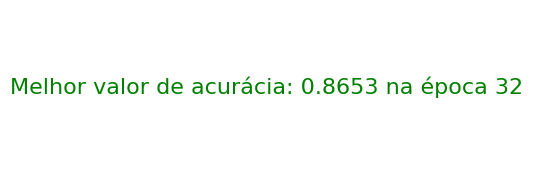

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')
ax.text(0.5, 0.5, f"Melhor valor de acurácia: {melhor_val_acc:.4f} na época {melhor_epoca}",
        fontsize=16, ha='center', va='center', color='green')
plt.show()


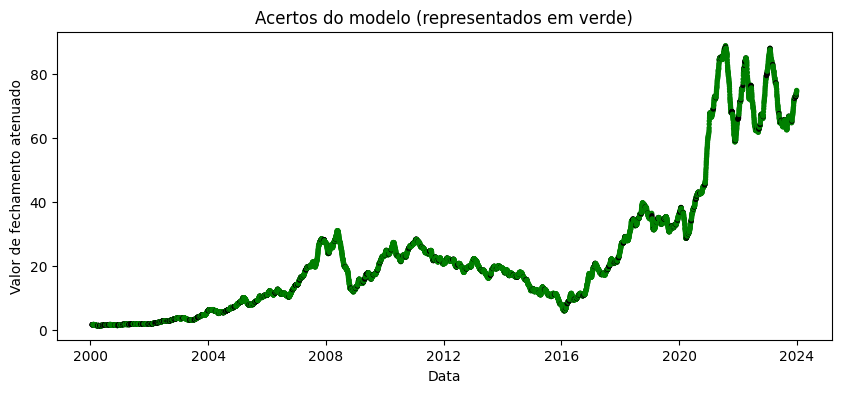

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

df_train["Date"] = pd.to_datetime(df_train["Date"], errors="coerce")
df_test["Date"]  = pd.to_datetime(df_test["Date"], errors="coerce")

plt.scatter(df_train["Date"], df_train["Smoothed_Close"],
            c=np.where(pred_train.flatten() == y_train, "green", "black"), s=8)
plt.scatter(df_test["Date"], df_test["Smoothed_Close"],
            c=np.where(pred_test.flatten() == y_test, "green", "black"), s=8)

plt.ylabel("Valor de fechamento atenuado")
plt.xlabel("Data")
plt.title("Acertos do modelo (representados em verde)")

#plt.grid(True, linestyle="--", alpha=0.1)
plt.show()

Confusion matrix:
 [[533  68]
 [ 94 508]]
Precision: 0.8819  |  Recall: 0.8439

Classification report:
               precision    recall  f1-score   support

           0     0.8501    0.8869    0.8681       601
           1     0.8819    0.8439    0.8625       602

    accuracy                         0.8653      1203
   macro avg     0.8660    0.8654    0.8653      1203
weighted avg     0.8660    0.8653    0.8653      1203



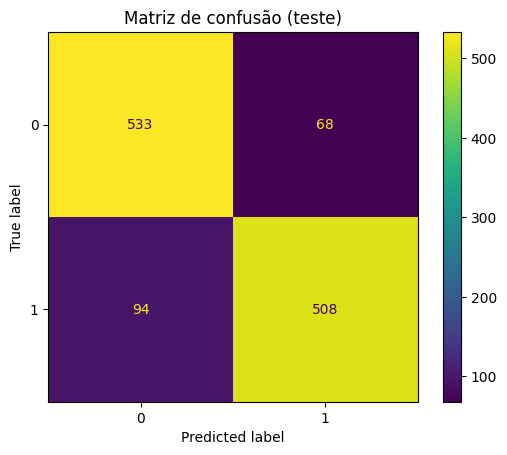

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, ConfusionMatrixDisplay

#Métricas
cm = confusion_matrix(y_test, pred_test)
prec = precision_score(y_test, pred_test, zero_division=0)
rec  = recall_score(y_test, pred_test, zero_division=0)

print("Confusion matrix:\n", cm)
print(f"Precision: {prec:.4f}  |  Recall: {rec:.4f}")
print("\nClassification report:\n", classification_report(y_test, pred_test, digits=4))

# 4) (opcional) Plot da matriz de confusão
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot(values_format="d")
plt.title("Matriz de confusão (teste)")
plt.show()

Esse é um modelo que tem um precision mais alto que o recall, o que significa que o modelo comete poucos falsos positivos, o que para o caso de compra de ações é positivo, já que um falso positivo representa uma compra de ação em momento desfavorável, o que incorre em prejuízos.

# Retorno Financeiro

A fim de comparar os rótulos obtidos através do modelo ajustado com os rótulos definidos por especialistas para compra e venda de ações vamos considerar que a cada róutulo 1 uma ação é comprada pelo preço de fechamento do dia anterior, e que quando o rótulo é 0 uma ação é vendida, também pelo valor de fechamento do dia anterior. Esse modelo de função tem apenas uma função demonstrativa a fim de comparar os comportamentos dos dados de treino e dos dados ajustados.

In [ ]:
df = pd.concat([df_train, df_test])

In [ ]:
y_predito = pd.concat([pd.Series(pred_train.flatten()), pd.Series(pred_test.flatten())])
print(y_predito.head())
print(y_predito.unique())
print(y_predito.value_counts())

0    0
1    0
2    0
3    0
4    0
dtype: int64
[0 1]
0    3882
1    2129
Name: count, dtype: int64


In [ ]:
df_modelo = pd.concat([df["Date"], df["Close"], y_predito], axis=1)

In [ ]:
df_modelo.columns = ['Date', 'Close', 'Label']
df_modelo.head()

,Date,Close,Label
0,2000-01-24,1.829122,0
1,2000-01-25,1.829122,0
2,2000-01-26,1.813879,0
3,2000-01-27,1.829122,0
4,2000-01-28,1.829122,0


In [ ]:
def retorno_financeiro(df, caixa_inicial, acoes_inicial):
  Ci = caixa_inicial
  Qi = acoes_inicial
  rotulos = df["Label"]
  precos = df["Close"]
  patrimonio = []
  patrimoio_inicial = Ci + (Qi * precos.iloc[0])
  for i in range(1, len(rotulos)):
    if rotulos.iloc[i] == 1:
      Ci = Ci - (precos.iloc[i-1])
      Qi = Qi + 1
    elif rotulos.iloc[i] == 0:
      Ci = Ci + (precos.iloc[i-1] )
      Qi = Qi - 1
    patrimonio.append(Ci + (Qi * precos.iloc[i]))

  patrimonio_final = patrimonio[-1]
  print(f"O patrimonio inicial: {patrimonio[0]:.2f}")
  print(f"O patrimônio final obtido foi de: {patrimonio_final:.2f}")
  return patrimonio

In [ ]:
retorno_especialista = retorno_financeiro(df, 10000, 10000)

O patrimonio inicial: 28291.22
O patrimônio final obtido foi de: 922556.08


In [ ]:
retorno_modelo = retorno_financeiro(df_modelo, 10000, 10000)

O patrimonio inicial: 28291.22
O patrimônio final obtido foi de: 663816.62


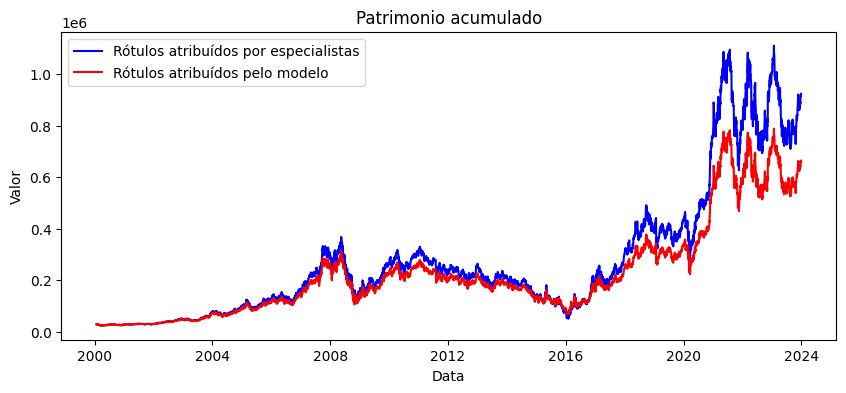

In [ ]:
plt.figure(figsize=(10,4))

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df_modelo["Date"]  = pd.to_datetime(df_modelo["Date"], errors="coerce")

plt.plot(df["Date"][1:], retorno_especialista, color="blue", label="Rótulos atribuídos por especialistas")
plt.plot(df_modelo["Date"][1:], retorno_modelo, color="red", label="Rótulos atribuídos pelo modelo")


plt.ylabel("Valor")
plt.xlabel("Data")
plt.title("Patrimonio acumulado")
plt.legend()

plt.show()

Pela curva de património acumulado fica fácil de visualizar como o modelo performa de maneira positiva durante os primeiros anos, que representam o conjunto de treino, porém perde performance quando trata dos dados do conjunto de teste. Foram testadas diversas arquiteturas de rede LSTM para esse problema, mas esse é um comportamente persistente. O uso de duas redes convolucionais antes das camadas LSTM pareceram ter um resultado positivo no modelo, já que esse tipo de camada é responsável pelo aprendizado de padrões mais curtos, o que é muito significativo em um problema como esse.

### Referências

OBEIDAT, Yazan M.; ALQUDAH, Ali M. A hybrid lightweight 1D CNN-LSTM architecture for automated ECG beat-wise classification. Biomedical Signal Processing and Control, v. 70, p. 103001, 2021. DOI: 10.1016/j.bspc.2021.103001.Acesso em: 04 set. 2025.

ALSUMAIDAEE, Ameer A.; ALI, Haider H.; IBRAHIM, Qusay H.; et al. Switchgear corona faults detection using hybrid 1D-CNN-LSTM architecture. Energies, v. 16, n. 6, p. 2680, 2023. DOI: 10.3390/en16062680. Acesso em: 04 set. 2025.

KIM, Jaedong; OH, Seunghwan; KIM, Heesoo; CHOI, Woosung. Tutorial on time series prediction using 1D-CNN and BiLSTM: A case example of peak electricity demand and system marginal price prediction. Engineering Applications of Artificial Intelligence, v. 126, p. 106817, 2023. ISSN 0952-1976. Disponível em: https://doi.org/10.1016/j.engappai.2023.106817. Acesso em: 01 set. 2025.


AADHITYA, A.; RAJAPRIYA, R.; VINEETHA, R. S.; BAGDE, Anurag M. Predicting Stock Market Time-Series Data using CNN‑LSTM Neural Network Model. Disponível em: https://arxiv.org/abs/2305.14378. Acesso em: 01 set. 2025.

JALALI, M. W.; SAIDI, B.; FARAHMAND, H.; PANAH, M. A. R. Scalable AI-driven air quality forecasting and classification for public health. Discover Applied Sciences, v. 7, article number unavailable, 2025. DOI: não localizado. Disponível em: URL se houver. Acesso em: 4 set. 2025.

THONGJAMROON, Joompol; PHIMPHISAN, Songgrod; SRIWIBOON, Nattavut. An explainable CNN–LSTM framework for monthly crude oil price forecasting using WTI time series data. Journal of Robotics and Control, v. 6, n. 5, p. —-, 2025. DOI: 10.18196/jrc.v6i5.26609. Acesso em: 04 set. 2025.